# CS 6140 Machine Learning: Assignment - 4 (Total Points: 100)
## Prof. Ahmad Uzair 

## Q1. Random Forest (50 points) 

**Random forests**, also known as **Random Decision Forests**, are an ensemble learning method for classification, regression, and other problems that works by training a large number of **decision trees**. For classification tasks, the random forest's output is the class chosen by the majority of trees. The mean or average prediction of the individual trees is returned for regression tasks. In this assignment we will be using Random Forest Classifier to predict the possibility of breast cancer being benign or not.

Note that the code for building a decision tree will be similar to your first assignment. Feel free to reuse the code from your first assignment but be ware of the differences.

In [37]:
# Do not change anything in this cell.
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

We are using the breast cancer dataset provided in scikit-learn. Here is a look at your dataset.

In [38]:
# Do not change anything in this cell.
data = datasets.load_breast_cancer()
X = data.data
y = data.target

In [39]:
# Do not change anything in this cell.
data

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For

In [40]:
# Write a function to calculate the entropy. We will be using this to calculate
## the information gain for decision tree.
def entropy(y):
    # Write your code here
    class_labels = np.unique(y)
    # Initialize the entropy
    entropy = 0
    # Calculate the entropy
    for cls in class_labels:
        p_cls = len(y[y == cls]) / len(y)
        entropy += (-p_cls * np.log2(p_cls))

    return entropy
    return None

In [41]:
# Do not change anything in this cell.
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [42]:
# Write code in this cell to build your Decision Trees used for Random Forest Classifier
#This will be similar to assignment 1, but keep in mind that we will randomly pick 
#a subset of features for splitting, at then choose the best variable/split-point among those
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, num_features=None):
        # Initialize the min_split,max_depth, root and num_features are set to None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_features = num_features
        self.root = None

    # Function to train the decision tree
    def fit(self, X, y):
        
        """
        Function to train the tree.
        X: Features
        Y: Target
        """
        self.num_features = X.shape[1] if not self.num_features else min(self.num_features, X.shape[1])
        self.root = self.build_tree(X, y)

    # Write a function to predict the results for a given dataset, using the tree you built 
    #and the tree traversal function
    def predict(self, X):
        """
        Prediction function to calculate the all the predictions of the matrix of features 
        provided using make_predictions function
        X: Matrix of features
        Returns predictions
        """
        return self.tree_traversal(X, self.root)

    # build the decision tree
    def build_tree(self, X, y, depth=0):
        """
        This will be a recursive function to build the decision tree.
        X: The data that you will be using for your assignment
        y: Target
        depth: Current depth of the tree
        Returns the leaf node
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria should be when depth equals or exceeds max depth
        # or there is only one label at the node
        # or when n_samples gets smaller than min_samples_split
        if (depth > self.max_depth or n_labels == 1 or n_samples <= self.min_samples_split):
            leaf_value = self.max_frequency_label(y)
            return Node(value=leaf_value)
        # select the features **randomly**. Hint: you can use functions like np.random.choice
        feature_idxs = np.random.choice(n_features, int(n_features / 10))

        # find the best split according to information gain
        best_feat, best_thresh = self.optimal_criterion(X, y, feature_idxs)
      
        # Take the result from the split and recuisively grow the tree
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self.build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def optimal_criterion(self, X, y, feature_idxs):
        """
        Find the optimal criterion for the split of the tree, using the selected features.
        X: dataset
        y: target
        feature_idxs: randomly selected feature idxs
        Return split index and threshold
        """
        # initialize the best gain
        best_gain = -1
        for feature_index in feature_idxs:
            # Find unique threshold values
            possible_thresholds = np.unique(X[:, feature_index])
            for threshold in possible_thresholds:
                #dataset_left, dataset_right = self._split(X[:, feature_index], threshold)
                curr_info_gain = self._information_gain(y, X[:, feature_index], threshold)
                if curr_info_gain > best_gain:
                    best_gain = curr_info_gain
                    best_feature_index = feature_index
                    best_thres = threshold

        # Best feature among the features
        split_idx = best_feature_index
        # Best threshold for the best feature
        split_thresh = best_thres
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        """
        Function to return the information gain
        y: target
        X: data
        split_thresh: threshold for split
        Return Information gain
        """
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        entropy_left = entropy(y[left_idxs]) * len(left_idxs) / len(y)
        entropy_right = entropy(y[right_idxs]) * len(right_idxs) / len(y)
        information_gain = parent_entropy - entropy_left - entropy_right
        return information_gain

    def _split(self, X_column, split_thresh):
        """
          (Already implemented)
          The split function 
          X_column: data
          split_thresh: threshold value
          Return left_idxs, right_idxs
          """
        # Function to split the tree
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
  
    def tree_traversal(self, x, node):
        """
          Tree traversal method which returns (one of) the leaf node value
          x: data
          node: node of the tree
          """
        if node.is_leaf_node():
            return node.value
  
        if x[node.feature] <= node.threshold:
            return self.tree_traversal(x, node.left)
        return self.tree_traversal(x, node.right)

    def max_frequency_label(self, y):
        """
          Determine the target label with maximum frequency. Hint: You can use collections.Counter()
          y: target
          """
        most_common = np.argmax(np.bincount(y))
        return most_common


In [43]:
def bootstrap_sample(X, y):
    # Function for bootstrap sampling. Hint: use np.random.choice for idxs
    idxs = np.random.choice(range(X.shape[0]), X.shape[0])
    X_sample, y_samples = X[idxs], y[idxs]
    return X_sample, y_samples

def most_common_label(y):
    """
      Determine the target label with maximum frequency. Again, you can use collections.Counter()
      y: target
      """
    most_common = np.argmax(np.bincount(y))
    return most_common

In [44]:
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, num_features=None):
        # Initialize the variabes
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_features = num_features
        self.trees = []

    def fit(self, X, y):
        """
        Create n_tree decision trees using the training data
        X: data
        y: target
        """
        for i in range(self.n_trees):
            X_sample, y_samples = bootstrap_sample(X, y)
            tree = DecisionTree(self.min_samples_split, self.max_depth, self.num_features)
            tree.fit(X_sample, y_samples)
            self.trees.append(tree)

    def predict(self, X):
        """
        Write a predict function to make predictions
        X: data
        Return predictions
        """
        y_pred = []
        for i in range(len(X)):
            preds = []
            for tree in self.trees:
                preds.append(tree.predict(X[i]))
            y_pred.append(most_common_label(preds))
        return y_pred

In [45]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [55]:
# Do not change anything in this cell
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
for n_trees in [1,3,5,10,20]:
    clf = RandomForest(n_trees=n_trees, max_depth=10)
    start = time.time()
    clf.fit(X_train, y_train)
    train_finish = time.time()
    y_pred = clf.predict(X_test)
    test_finish = time.time()
    acc = accuracy(y_test, y_pred)
    print (f"Num of trees : {n_trees} Accuracy: {acc:.2f} Training took {train_finish-start:.2f}s Testing took {test_finish - train_finish:.2f}s")

Num of trees : 1 Accuracy: 0.89 Training took 0.36s Testing took 0.00s
Num of trees : 3 Accuracy: 0.91 Training took 0.80s Testing took 0.00s
Num of trees : 5 Accuracy: 0.92 Training took 1.47s Testing took 0.00s
Num of trees : 10 Accuracy: 0.92 Training took 3.10s Testing took 0.00s
Num of trees : 20 Accuracy: 0.93 Training took 5.96s Testing took 0.01s


## Q2. Clustering (35 points) 

### K-Means Clustering
For this question, you will use the **K-Means** clustering algorithm to cluster the yeast dataset. You will experiment with different k values, and report the Sum of Squared Errors (see below) for each k.



### Sum of Squared Errors (SSE)
Assume that we have a clustering for our data $X$ having $K$ clusters. Each cluster is characterized by it’s centroid $C_k$ . The sum of squared error criterion for one cluster can be defined as:
$$SSE(X,C =k)= \sum_{x_i \in cluster_k}||x_i −C_k||2 $$ 
then, the overall SSE for the K clusters can be calculated as:

$$ SSE(X)= \sum_{k=1}^K SSE(X,C=k)$$
SSE provides a notion of how compact the clusters are and we are going to favor clusters that are more compact, hence we will look for clusterings that minimize SSE. This is an internal clustering quality criterion as we can estimate it using just the cluster labels.

In [47]:
import numpy
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt

In [48]:
# =============================================================================#
# Load a CSV file
def load_csv(filename):
    data = pd.read_csv(filename, header=None)
    dataset = data.values
    return dataset

In [49]:
# =============================================================================#
'''
Initialize the k centroids.
'''
def initialize_centroids(k, dataset):
    centroids = []
    for i in range(k):
        centroids.append(dataset[i])
    return centroids


In [50]:
# =============================================================================#
def calculate_znk(data, centroids, k, n):
    '''
    Assign each point to the closest centroid, using a Matrix Z to represent the assignments
    '''
    znk = numpy.array([[0 for i in range(k)] for j in range(n)])
    for i in range(n):
        distance_to_cen = []
        for j in range(k):
            # calculate the distance squared
            distance = 0
            for m in range(data.shape[1]):
                distance += (data[i, m] - centroids[j][m]) ** 2
            distance_to_cen.append(numpy.sqrt(distance))
        # assign the closer centroid index to be 1
        znk[i, numpy.argmin(distance_to_cen)] = 1
    return znk

In [51]:
# =============================================================================#
def calculate_centroids_and_SSE(k, znk, data, cen):
    '''
    Calculate the k centroids and the SSE
    '''
    centroids = []
    #clusters = []
    for i in range(k):
        cluster_i = numpy.where(znk[:, i] == 1)[0]
        #clusters.append(len(cluster_i))
        centroid = []
        for j in range(data.shape[1]):
            if len(cluster_i) == 0:
                centroid = cen[i]
                break
            else:
                centroid.append(sum(data[cluster_i, j]) / len(cluster_i))
        centroids.append(centroid)

    total_SSE = 0
    for i in range(data.shape[0]):
        for j in range(k):
            # calculate the distance squared
            if not centroids[j][0]:
                continue
            total_SSE += znk[i, j] * calculate_d_squared(data[i, :], centroids[j])
    return centroids, total_SSE

In [52]:
# This function calculate the squared distance between two vectors(points)
def calculate_d_squared(x, centroid):
    distance = 0
    for i in range(x.shape[0]):
        distance += (x[i] - centroid[i]) ** 2
    return distance

In [53]:
# =============================================================================#
def k_means_algorithm(dataset, k, max_iterations, thresh = 0.01):
    '''
    Do k-means by iteratively calculating the centroids and assigning the data points to one of the centroids
    until either we reach the max_iter or SSE does not decrease by more than the threshold.
    Do not use the last column, as they are the labels.
    '''
    centroids = initialize_centroids(k, dataset)
    n = len(dataset)
    data = dataset[:, 0:dataset.shape[1] - 1]
    cen = []
    prev_SSE = math.inf
    for i in range(max_iterations):
        znk = calculate_znk(data, centroids, k, n)
        centroids, total_SSE = calculate_centroids_and_SSE(k, znk, data, centroids)
        if prev_SSE - total_SSE <= thresh:
            #stop when SSE does not decrease by more than the threshold
            return prev_SSE, znk, centroids
        cen.append(centroids)
        #data.append(total_SSE)
        prev_SSE = total_SSE
    return prev_SSE, znk, centroids



SSE for k= 2 is 94.16634322044357
SSE for k= 4 is 70.77402837824934
SSE for k= 6 is 54.78035253521831
SSE for k= 8 is 48.80812672080955
SSE for k= 10 is 44.99032745150484
SSE for k= 12 is 41.523432060297715
SSE for k= 14 is 39.80860317468567
SSE for k= 16 is 37.6736423178586
SSE for k= 18 is 36.30823794193829
--------------------------------------------------


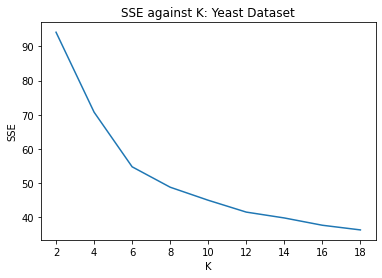

In [54]:
# =============================================================================#
# MAIN FUNCTION, DO NOT MODIFY
dataset_name = 'yeastData.csv'
# Careful, the dataset also consists of labels
dataset = load_csv(dataset_name)
max_iterations = 1000
sum_sq_error = []


K = numpy.arange(2, 20, 2)
for k in K:
    SSE, znk, centroids = k_means_algorithm(dataset, k, max_iterations)
    sum_sq_error.append(SSE)
    print("SSE for k= ", end='')
    print(k, end='')
    print(' is ', end='')
    print(SSE)


print("-" * 50)
plt.plot(K, sum_sq_error)
plt.title("SSE against K: Yeast Dataset")
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()


## Q3. Theory (15 points) 

1.(4 points) Verify that if we minimize the sum-of-squares error between a set of training values {$t_n$} and a single predictive value $t$, then the optimal solution for $t$ is given by the mean of the {$t_n$}. 

2.(7 points) Consider the K-means algorithm. Show that as a consequence of there being a finite number of possible assignments for the set of discrete indicator variables $z_{nk}$, and that for each such assignment there is a unique optimum for the centroids, the K-means algorithm must converge after a finite number of iterations.

3.(4 points) In Q2 we initialize the centroids of the clusters by simply picking the first $k$ data points from the dataset. There are many alternative ways. Provide two other ways of initializing the centroids. 


1. For the single predicative value,

$$SSE = \sum_{i=1}^n(t_i - t)^2 $$

$$SSE = nt^2 + \sum_{i=1}^nti-2\sum_{i=1}^nti*t $$

$$\frac {\partial SSE}{\partial t} = 2nt - 2\sum_{i=1}^nti $$

$$\frac {\partial^2 SSE}{\partial t^2} = 2n $$

We can see that $\frac {\partial^2 SSE}{\partial t^2}=2n>0$, so $\frac {\partial SSE}{\partial t}$ is monotonically increasing.

Let $\frac {\partial SSE}{\partial t} = 0$, we have 

$$\frac {\partial SSE}{\partial t} = 2nt - 2\sum_{i=1}^nt_i = 0$$

$$2nt =2\sum_{i=1}^nt_i $$

$$t =\frac{1}{n}\sum_{i=1}^nt_i $$

where $\frac{1}{n}\sum_{i=1}^nt_i$ is the mean of the ${t_n}$.

Since $\frac {\partial SSE}{\partial t}$ is monotonically increasing and $\frac {\partial SSE}{\partial t}=0$ when $t =\frac{1}{n}\sum_{i=1}^nt_i $, so SSE has only 1 global minimum point. 

So the optimal solution for t is the mean of the ${t_n}$

2. 

For K-means clustering, the objective function:

$$J=\sum_{n=1}^N\sum_{n=1}^Nz_{nk}\parallel x_n-\mu_k \parallel^2$$

Since there are finite number of possible assignments fo the $z_{nk}$, each point have a unique minimum with to the ceratain centroid $\mu$. After a finite number of iterations, the k-means clustering algorithm will converage, when $z_{nk}$ is not changing. If the $z_{nk}$ not changingm, the centroids $\mu_k$ will keep the same, no changes will make to the objective function J.

3.

Method 1 (k-means++):

* Choose first centroid randomly from the data points
* For each data points, canculate the distance to choosen centroids
* Choose new data point using the weighted probability distributation based on the distance calculated in the last step
* Repeat last two steps until finsh choosing k centroids.  

Method 2:

* Calculate the $\parallel \textbf{x} \parallel $ and sort the dataset based on that. 
* Split the sorted dataset to k pieces
* Calculated the mean of each piece as the centroids

